# Intro to Feature Engineering

All about what to do with your data features after you are done cleaning your data set. Feature engineering is not commonly discussed, but it is a time-consuming and sometimes very important step to complete before implementing and testing models. Given a relatively non-garbage data set, creation of meaningful features can sometimes bring a few more percentage points of accuracy or $ R^2 $ compared to only using the provided data features.

**Remark.** To be perfectly frank, almost no one will be doing extensive feature engineering, as hopefully all of you have chosen relatively nice data sets that require minimal cleaning or feature engineering; i.e. they are mostly model-ready. We will cover today, in temporal order of the data science process,

* feature scaling
* feature engineering: transformations, PCA
* feature selection: manual, RFECV

**Remark.** One can argue that feature selection and engineering are a cycle. But in order to demonstrate feature selection, which is important when there are a lot of features, we need to show some feature engineering first. We will create features, then choose the ones we want.

**Remark.** No amount of feature engineering can fix a bad data set. Garbage in, garbage out.

Try not to fall asleep! I will probably skip the PCA math unless anyone objects. uwu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## Feature scaling

Feature *scaling* is the probably the first kind of feature "engineering" that one will perform on their raw dataset after it is cleaned up enough for use. The idea of scaling is to bring all the continuous features to the same *scale*, which intuitively means the same rough magnitude. Usually, this involves subtracting the sample mean from a feature column, and then dividing by the feature column's sample standard deviation, as then the column will have a mean of 0 and unit variance. So given an $ n \times 1 $ feature (column) vector $ \mathbf{x}^{(k)} $, the $ k $th column out of say $ m \ge k $ feature columns, our *standardized feature* $ \widetilde{\mathbf{x}}^{(k)} $ is

$$ \widetilde{\mathbf{x}}^{(k)} = \frac{\mathbf{x}^{(k)} - \bar{x}^{(k)}\mathbf{1}}{s^{(k)}} $$

$ \bar{x}^{(k)} $ is the sample mean of values in $ \mathbf{x}^{(k)} $, $ s^{(k)} $ is our sample standard deviation for the $ k $th feature column, and $ \mathbf{1} $ is the $ n \times 1 $ unit vector.

**Remark.** The superscript parentheses notation emphasizes that these are **not** exponents and frees up the subscript for subscripting observation rows. I will continue to use the $ \widetilde{\phantom{x}} $ notation to indicate that some variable is standardized with mean 0 and unit variance.

### Why we scale features

Why do we care? Because some models are sensitive to feature scaling, for example in linear regression. Recall that a typical linear estimator is given by

$$ \hat{f}(\mathbf{x} \mid \hat{\beta}) = \hat{\beta}_0 + \sum_{k = 1}^m\hat{\beta}_kx_k $$

As usual, $ \hat{\phantom{x}} $ denotes estimations, $ \begin{bmatrix}  \ x_1 \ \dots \ x_m \ \end{bmatrix} $ is a $ 1 \times m $ observation (row) vector, and $ \begin{bmatrix} \hat{\beta}   \hat{\beta}_0 \ \dots \ \hat{\beta}_m  \end{bmatrix} ^\text{T} $ is an $ m \times 1 $ column vector of our parameters. Suppose that the $ i $th feature has very small values, while the $ j $th feature has very large values, and there is little multicollinearity among predictors. How can we tell, from the magnitude of the coefficients, whether feature $ i $ i more important that feature $ j $? It is quite difficult if $ i, \, j $ have different scales, but if we put them on the same scale, then we can tell by glancing at the coefficients. However, for ordinary least squares, the fit does not change.

The story is different if we are *regularizing*. In $ L_1 $- and $ L_2 $-regularized linear regression, variable scale **significantly** impacts the fit of the model. Recall that for an estimator $ \hat{f} $, the objective function $ L(\mathbf{X} \mid \hat{\beta}) $ that we want to minimize when regularizing, assuming we want to minimize mean squared error, is

$$ L(\mathbf{X} \mid \hat{\beta}) = \frac{1}{n}\sum_{k = 1}^n\big(y_k - \hat{f}(\mathbf{x}_k \mid \hat{\beta})\big)^2 + \lambda||\hat{\beta}||_p^p $$

Here I denote our $ n \times m $ data matrix as $ \mathbf{X} $, with each $ \mathbf{x}_k = [ \ x_k^{(1)} \ \ldots \ x_k^{(m)}\ ] $ a $ 1 \times m $ row vector an observation in $ \mathbf{X} $. As usual, $ \lambda > 0 $, and

$$ \lambda||\beta||_p^p = \lambda\sum_{k = 1}^m|\beta_k|^p, \, p = 1, \, 2 $$

I.e. $ || \, \cdot \, ||_p^p $ is the $ p $-norm to the $ p $th power, for $ p = 1, \, 2 $. It is clear that since the fit now depends on the size of the $ \hat{\beta}_k $ terms, larger $ \hat{\beta}_k $ terms corresponding to features with smaller values will be more heavily penalized, and affect the biased fit of the estimator $ \hat{f} $ and the final choice of $ \hat{\beta} $. By scaling all the features, then we avoid any confounding effect on the fitting from differing variable scales, and the regularization will work as it should.

**Remark.** Gradient-based optimization methods, which are standard issue, are not *scale invariant*. Loosely this means that large values in a vector will disproportionately affect optimization, and can easily lead to numerical instabilities that cause the training process to **fail**.

**Remark.** Decision boundary based models such as decision trees are agnostic with regards to scale.

In `sklearn`, there exists a class called `StandardScaler` that performs this process for you. Again using the car data set,

In [5]:
# import StandardScaler
from sklearn.preprocessing import StandardScaler
raw_data = pd.read_csv("./data/auto_mpg_data.csv")
# split into X and y; deep copy to preserve raw
X, y = raw_data[raw_data.columns[:-1]].copy(), raw_data[raw_data.columns[-1]].copy()
print(X.head())
# standard scaler object
std_slr = StandardScaler()
# scale the feature data. note that since StandardScaler returns an nparray, we need to make a new dataframe
Xs = pd.DataFrame(std_slr.fit_transform(X), columns = X.columns)
print(Xs.head())

   cylinders  displacement  horsepower  weight  acceleration
0          8         307.0       130.0  3504.0          12.0
1          8         350.0       165.0  3693.0          11.5
2          8         318.0       150.0  3436.0          11.0
3          8         304.0       150.0  3433.0          12.0
4          8         302.0       140.0  3449.0          10.5
   cylinders  displacement  horsepower    weight  acceleration
0   1.483947      1.077290    0.664133  0.620540     -1.285258
1   1.483947      1.488732    1.574594  0.843334     -1.466724
2   1.483947      1.182542    1.184397  0.540382     -1.648189
3   1.483947      1.048584    1.184397  0.536845     -1.285258
4   1.483947      1.029447    0.924265  0.555706     -1.829655


/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


You can also do this manually in one line, with

In [7]:
# change ddof to 1 to calculate unbiased sample variance
print(((X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 0)).head())

   cylinders  displacement  horsepower    weight  acceleration
0   1.483947      1.077290    0.664133  0.620540     -1.285258
1   1.483947      1.488732    1.574594  0.843334     -1.466724
2   1.483947      1.182542    1.184397  0.540382     -1.648189
3   1.483947      1.048584    1.184397  0.536845     -1.285258
4   1.483947      1.029447    0.924265  0.555706     -1.829655


**Remark.** By default, `StandardScaler` does **not** correct for variance estimation bias; i.e. it divides by $ n $ instead of $ n - 1 $. This usually doesn't matter.

**Remark.** Why didn't we also scale the response? We scaled the features to remove scaling issues, which is not an issue with the response (only one scale). However, for multilayer neural networks, if the response is widely dispersed, then calculated gradients are numerically unstable and cause training to fail.

**Remark.** One other nice thing about scaling features. Given standardized features, in linear regression, $ \hat{\beta}_0 $ is thus equal to the conditional expectation of the estimated response $ \hat{y} $. Denoting each $ k $th scaled feature variable as $ \widetilde{x}^{(k)} $, and recalling that $ \mathbb{E}\left[\widetilde{x}^{(k)} \ \middle\vert \ \mathbf{X}\right] = 0 $, we have that

$$ \mathbb{E}[\hat{y} \mid \mathbf{X}] = \mathbb{E}\left[\hat{f}(\mathbf{x} \mid \hat{\beta}) \ \middle\vert \ \mathbf{X}\right] = \mathbb{E}\left[\hat{\beta}_0 + \sum_{k = 1}^m\hat{\beta}_k\widetilde{x}^{(k)} \ \middle\vert \ \mathbf{X}\right] = \hat{\beta}_0 + \sum_{k = 1}^m\hat{\beta}_k\mathbb{E}\left[\widetilde{x}^{(k)} \ \middle\vert \ \mathbf{X}\right] = \hat{\beta}_0 $$

If our $ \hat{f} $ is an unbiased estimator, then $ \mathbb{E}[y \mid \mathbf{X}] = \mathbb{E}[\hat{y} \mid \mathbf{X}] = \hat{\beta}_0 = \beta_0 $.

## Feature engineering

The term *feature engineering* is a relatively broad term that can involve something as simple as making dummy variables or taking differences of continuous features to writing a novel algorithm to generate a new, useful feature from several of the original features. Usually feature engineering involves domain knowledge as well, as domain knowledge helps guide one's selection and engineering of useful features from the original features in the data set.

One could technically skip this section or even devote a full lecture to engineering features, and real big brains have algorithms designed to automatically generate new features. To give a taste of some (ratchet) feature engineering, I will discuss and show an example of transforming continuous features, as well as discuss *principal components analysis*, a dimensionality reduction technique which as a side effect can also generate features.

### Transformations

As the title says, one can perform arithmetic operations on features to introduce/remove linearity/nonlinearities, take differences and so on. Returning to the car data set, let's make some more features to add to what's in `X`, our matrix of feature columns. Specifically, we will add the columns

* `log_*` - natural log of features in `X`. This is ok since our unscaled features are positive.
* `invsq_*` - inverse square root of features in `X`, i.e. $ \forall x^{(k)} $, we define $ q^{(k)} \triangleq 1 / \sqrt{x^{(k)}} $. This is also ok since all our unscaled features are positive.

**Remark.** If I haven't explained yet, $ \forall $ means "for all". It's an upside down A, see? Again $ \triangleq $ means "is defined as".

In [8]:
# new dataframes for log and inverse sqrt features (use lambda function with map, shorten name)
log_X = np.log(X)
log_X.columns = list(map(lambda x: "log_" + x[:5], X.columns))
invsq_X = np.power(X, -0.5)
invsq_X.columns = list(map(lambda x: "invsq_" + x[:5], X.columns))
# let's also scale them
log_Xs = pd.DataFrame(std_slr.fit_transform(log_X), columns = log_X.columns)
invsq_Xs = pd.DataFrame(std_slr.fit_transform(invsq_X), columns = invsq_X.columns)

I originally did this as a way to try and linearize the features of the data. For example, looking at scaled original features, we see

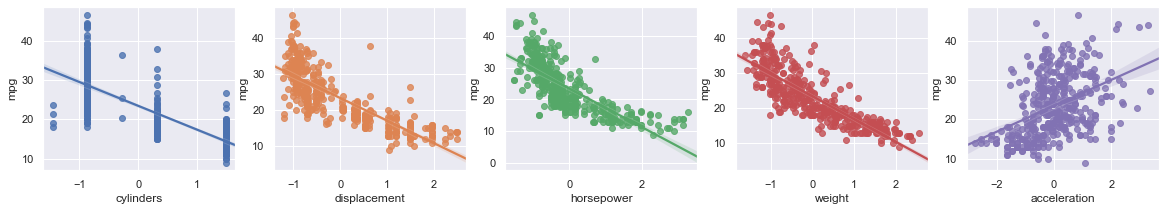

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = len(X.columns), figsize = (20, 3))
for col, ax in zip(Xs.columns, axs):
    sns.regplot(x = Xs[col], y = y, ax = ax)

Clearly we can drop `cylinders` and `acceleration` if we are trying to fit a linear model. But we want to keep the three (highly correlated) other features. Therefore, we try some nonlinear transformations, as `displacement`, `horsepower`, and `weight` seem to display exponentially decaying or power relationships with `mpg`. We then graph `log_displ`, `log_horse`, `log_weigh` and `invsq_displ`, `invsq_horse`, `invsq_weigh` respectively. 

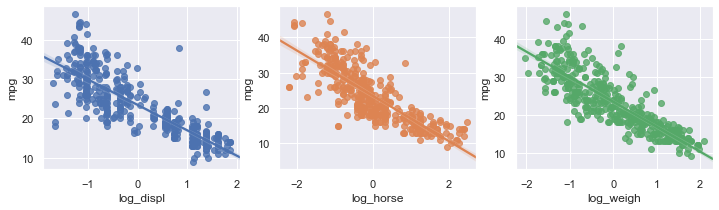

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = len(X.columns) - 2, figsize = (12, 3))
for col, ax in zip(log_Xs.columns[1:-1], axs):
    sns.regplot(x = log_Xs[col], y = y, ax = ax)

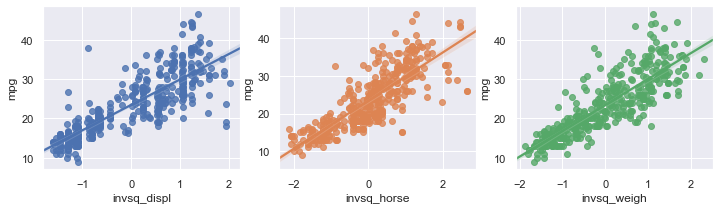

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = len(X.columns) - 2, figsize = (12, 3))
for col, ax in zip(invsq_Xs.columns[1:-1], axs):
    sns.regplot(x = invsq_Xs[col], y = y, ax = ax)

These seem to be more linear, but have more dispersion due to the nature of the nonlinear transformations we used. I will not prove or show this here, but take my word that using some of the new pseudo-linearized features did help to slightly improve test performance with a linear regression model fitted with $ L_1 $-normed least squares (lasso). This data set is too small for a conclusive statement however, as different train/test splits lead to quite different results.

## PCA

PCA is the acronym for *principal components analysis*. I am not a real big brain so I don't have a real rigorous definition, but what the method does is take a set of observations of possibly correlated continuous features into a set of linearly **uncorrelated** variables called *principal components*, in a way that the principal components are ordered by how much variance in the data each one accounts for. Importantly, PCA is **scaling sensitive**. So that is another application of standardizing features, as if we want to perform PCA, we **require** that the features are of the same scale with 0 mean.

### Intuition

The big point to understand is that in the context of continuous features, say for a **standardized** $ n \times m $ feature matrix $ \widetilde{\mathbf{X}} $, PCA for a natural $ \lambda \le m $ will return an $ n \times \lambda $ feature matrix $ \mathbf{M} $ such that the columns of $ \mathbf{M} $ are an *orthogonal basis* for the column space of $ \widetilde{\mathbf{X}} $. Cool, right?

A simpler way to think about it is dimensionality reduction, from $ m $ dimensions to $ \lambda \le m $ dimensions, where each of the $ \lambda $ dimensions are structured in descending order of how much variability they can explain. This is useful for defining new explanatory features while reducing dimensionality.

**Remark.** This $ \lambda $ is not the same as the one used in regularization. I just realized that $ l $ and $ 1 $ look the same, and needed a different symbol.

**Remark.** For those of you who have taken linear algebra, the next section will **not** discuss the SVD approach. Computing the explicit decomposition is slow with very large matrices, and will give you all $ m $ principal components. If you only want strictly $ \lambda < m $ top principal components, for small $ \lambda $ relative to $ m $, the method of *power iteration* is preferred. You can read more by checking out [this lecture](http://theory.stanford.edu/~tim/s15/l/l8.pdf) from Stanford big brains Roughgarden and Valiant.

**Remark.** Tell me **right now** if you want me to skip the math!

### Calculating the first principal component

Consider our **standardized** $ n \times m $ feature matrix $ \widetilde{\mathbf{X}} $, where each (observation) row is a $ 1 \times m $ row vector $ \widetilde{\mathbf{x}}_k = [ \ \widetilde{x}_k^{(1)} \ \ldots \ \widetilde{x}_k^{(m)} \ ] $. For natural $ \lambda \le m $, our new $ n \times \lambda $ matrix of orthogonal principal components $ \mathbf{M} $ is such that each $ k $th row of $ \mathbf{M} $ is a $ 1 \times \lambda $ row vector $ \mathbf{r}_k = [ \ p_k^{(1)} \ \ldots \ p_k^{(\lambda)} \ ] $. Each $ p_k^{(j)} $ is given by

$$ p_k^{(j)} = \widetilde{\mathbf{x}}_k\mathbf{w}_j = \begin{bmatrix} \widetilde{x}_k^{(1)} \ \ldots \ \widetilde{x}_k^{(m)} \end{bmatrix}\begin{bmatrix} w_1^{(j)} \\ \vdots \\ w_m^{(j)} \end{bmatrix} = \sum_{i = 1}^m\widetilde{x}_k^{(i)}w_i^{(j)} $$

Here the $ m \times 1 $ column vector $ \mathbf{w}_j = [ \ w_1^{(j)} \ \dots w_m^{(j)} \ ]^\text{T} $ is one of $ \lambda $ column vectors that will be calculated such that for each $ k $th observation $ \widetilde{\mathbf{x}}_k $, we can calculate the $ j $th principal component value $ p_k^{(j)} $, where $ 1 \le j \le \lambda $. Note that $ ||w_j|| = 1 $; i.e. each $ \mathbf{w}_j $ must be a *unit vector*.

**Remark.** $ || \ \cdot \ || $ without a subscript is by default the *Euclidean norm*, the $ L_2 $ norm.

**Remark.** **Important note about terminology.** The terminology in PCA is vague and confusing, with the same terms used for different things. We establish that our new features from PCA are called *principal components* or *principal component scores*, and nothing else. Since PCA is also closely tied to computing eigenvectors and eigenvalues for the covariance matrix of $ \widetilde{\mathbf{X}} $, sometimes people confuse eigenvectors with the principal components. One can think of PCA as changing from the original feature space to a new vector space/coordinate system, and the eigenvectors are the axes of this new system, called the *principal axes* or *principal directions*. Eigenvectors are **not** the PCA-returned features!

**Remark.** See [this link](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca) for a good clarification of terminology and relationship to singular value decomposition (SVD).

We need to start with the first *principal component vector* (column of $ \mathbf{M} $), an $ n \times 1 $ column vector denoted as $ \mathbf{p}_1 = [ \ p_1^{(1)} \ \ldots \ p_n^{(1)} \ ]^\text{T} $. Recall that for each $ \widetilde{\mathbf{x}}_k $, each $ p_k^{(j)} $ in $ \mathbf{r}_k $ is ordered in descending order of how much variance is explained. We thus want to maximize $ ||\mathbf{p}_1|| $, which we can also write as $ ||\mathbf{p}_1|| = ||\widetilde{\mathbf{X}}\mathbf{w}_1|| $. In other words, we want to maximize all the $ p_k^{(1)} $ values for each observation $ \widetilde{\mathbf{x}}_k $ in $ \widetilde{\mathbf{X}} $. $ \mathbf{w}_1 $ is thus the result from

$$ \mathbf{w}_1 = \arg\max_{||\mathbf{w}|| = 1}\left\{\sum_{k = 1}^n\left(p_k^{(1)}\right)^2\right\} = \arg\max_{||\mathbf{w}|| = 1}\left\{||\mathbf{p}_1||^2\right\} = \arg\max_{||\mathbf{w}|| = 1}\left\{\sum_{k = 1}^n(\mathbf{x}_k\mathbf{w})^2\right\} = \arg\max_{||\mathbf{w}|| = 1}\left\{||\widetilde{\mathbf{X}}\mathbf{w}||^2\right\} $$

Note the condition $ ||\mathbf{w}|| = 1 $; i.e. all candidate vectors for $ \mathbf{w}_1 $ must be unit vectors. Now we just have $ \mathbf{p}_1 = \widetilde{\mathbf{X}}\mathbf{w}_1 $.

### Calculating further components

Let's denote our original matrix $ \widetilde{\mathbf{X}} $ as $ \mathbf{X}_{\mathbf{p}_1} $, the matrix we use to get the first principal component vector $ \mathbf{p}_1 $. In the power iteration method, we proceed recursively by replacing $ \mathbf{X}_{\mathbf{p}_1} $ with $ \mathbf{X}_{\mathbf{p}_2} \triangleq \mathbf{X}_{\mathbf{p}_1} - \mathbf{p}_1\mathbf{w}_1^\text{T} = \mathbf{X}_{\mathbf{p}_1} - \mathbf{X}_{\mathbf{p_1}}\mathbf{w}_1\mathbf{w}_1^\text{T} = \mathbf{X}_{\mathbf{p}_1}(\mathbf{I} - \mathbf{w}_1\mathbf{w}_1^\text{T}) $. Here $ \mathbf{I} $ is the $ m \times m $ *identity matrix*, i.e. it contains 1s on the main diagonal and 0s everywhere else, while $ \mathbf{w}_1\mathbf{w}_1^\text{T} $ is an $ m \times m $ matrix, the *outer product* of $ \mathbf{w}_1 $ with itself.

**Remark.** If we already computed $ \mathbf{p}_1 $, $ \mathbf{X}_{\mathbf{p}_1} - \mathbf{p}_1\mathbf{w}_1^\text{T} $ is the most computationally efficient in terms of multiplications, which are expensive.


Thus, if we have calculated $ i - 1 $ principal components, and have already computed $ \mathbf{X}_{\mathbf{p}_{i - 1}} $, $ \mathbf{w}_{i - 1} $, and $ \mathbf{p}_{i - 1} $, by computing 

$$ \mathbf{X}_{\mathbf{p}_i} \triangleq \mathbf{X}_{\mathbf{p}_{i - 1}} - \mathbf{p}_{i - 1}\mathbf{w}_{i - 1}^\text{T} $$

We can then compute the $ i $th principal component vector $ \mathbf{p}_i $ by first finding the right $ \mathbf{w}_i $ given by

$$ \mathbf{w}_i = \arg\max_{||\mathbf{w}|| = 1}\left\{||\mathbf{X}_{\mathbf{p}_i}\mathbf{w}||^2\right\} $$

Then as before, we have $ \mathbf{p}_i = \mathbf{X}_{\mathbf{p}_i}\mathbf{w}_i $. We now know how after computing $ \mathbf{p}_1 $ to compute the other principal component vectors $ \mathbf{p}_2, \ \ldots \mathbf{p}_\lambda $, where $ \lambda \le m $. 

Wow, that's enough math for now. Good thing you don't have to do this by hand: the computer does it for you. `sklearn` has a `PCA` class that uses SVD, with an options for how many components we want to keep, what method we want to compute the principal components, and so on. We will use PCA to calculate all 3 principal components from our original features `displacement`, `horsepower`, and `weight`.

In [25]:
# import and instantiate pca object
from sklearn.decomposition import PCA
pca = PCA()
# create new principal component features from our STANDARDIZED original features
X_pc = pd.DataFrame(pca.fit_transform(Xs[Xs.columns[1:-1]]), columns = ["pc_1", "pc_2", "pc_3"])

We will graph our new principal component features to see how `mpg` varies with them.

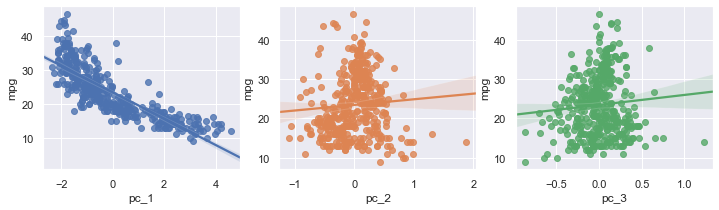

In [24]:
fig, axs = plt.subplots(nrows = 1, ncols = len(X.columns) - 2, figsize = (12, 3))
for col, ax in zip(X_pc.columns, axs):
    sns.regplot(x = X_pc[col], y = y, ax = ax)

Hm, this doesn't look so great. This is because `displacement`, `horsepower`, and `weight` are all nonlinear, while PCA assumes linearity between features. We can see that the first principal component `pc_1`, has a very well defined shape, and explains the variation well, while the other two components are blobs and basically contribute very little information. Let's try PCA on our engineered features `invsq_displ`, `invsq_horse`, and `invsq_weigh`. 

In [27]:
# these features are already standardized
invsq_Xs_pc = pd.DataFrame(pca.fit_transform(invsq_Xs[invsq_Xs.columns[1:-1]]),
                           columns = ["pc_invsq1", "pc_invsq2", "pc_invsq3"])

Again we graph our new principal component features and try to see how `mpg` varies with them.

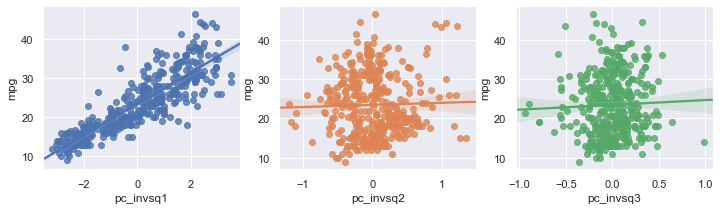

In [32]:
fig, axs = plt.subplots(nrows = 1, ncols = len(X.columns) - 2, figsize = (12, 3))
for col, ax in zip(invsq_Xs_pc.columns, axs):
    sns.regplot(x = invsq_Xs_pc[col], y = y, ax = ax)

See that our first principal component is pretty good, while again the other two are blobs that contribute little extra information.

## Feature selection

We have so many features, but are all the features going to be useful in our model? The answer is no. Some features will have significantly more predictive power than other features. And if you have a lot of features, in order to keep model runtime reasonable, reduce overfitting, and overall simplify the model, you are going to have to throw out a bunch of features and then try to select the best few that you want to keep. Feature selection deals with this issue.

There are two ways to go about doing this: the first is manually, and the second is automatically.

### Manual feature selection

Usually not too feasible when you have lots of features. We just did it with regards to the car data, when we decided to eliminate `cylinders` and `acceleration` due to their nonlinear variation with the response `mpg`, as we wanted to fit a linear model.

### Automatic feature selection

Fortunately, you don't have to do this by hand for large numbers of features. `sklearn` has a feature selection class called `RFECV`, which stands for *recursive feature elimination \[with\] cross validation*. It thus kills two birds with one stone, as not only does it help you select the most relevant features, but it will train the model with cross validation which improves average model performance. `RFECV` simply tries all possible subsets of the features, and given a limiting value $ k $, will identify the most relevant $ j \ge k $ features. This is much better than you doing it yourself.

**Remark.** Do realize this. Suppose we have $ m $ features. There are $ 2^m - 1 $ nonempty subsets of these features. With large $ m $, runtime is not trivial.

To give a demonstration of `RFECV`, we will fit a linear regression model by ordinary least squares (no regularization), using `RFECV` to choose the top 1+ features that we want to keep. We will use the default 3 folds for cross validation. We first combine all our features.

In [103]:
# combine all the features by joining the dataframes
X_tot = pd.concat([Xs, log_Xs, invsq_Xs, invsq_Xs_pc], axis = 1)
print("number of features: {0}".format(len(X_tot.columns)))

number of features: 18


Now we instantiate our `RFECV` object with a linear regression model, fit the data to the model using 3 fold cross validation, and select the best 1+ features.

In [112]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
# n_jobs parameters controls how many CPU cores you want to use; -1 for all
felr = RFECV(LinearRegression(), cv = 3, min_features_to_select = 1, n_jobs = 1)
# fit and automatically prune features
felr.fit(X_tot, y)

RFECV(cv=3,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=1, scoring=None, step=1, verbose=0)

We can retrieve a 1-0 integer mask to see which features were selected by accessing the `support_` attribute, and can access the `estimator_` attribute to access our `LinearRegression` model to retrieve its coefficients. The `score()` method also gives us the average $ R^2 $ of our model.

In [131]:
# print selected feature labels, their corresponding coefficients in our model, and model R^2
print("features:\n{0}\ncoefs:\n{1}\n\navg R^2: {2:.5f}".format(X_tot.columns[felr.support_], 
                                                         felr.estimator_.coef_, felr.score(X_tot, y)))

features:
Index(['cylinders', 'log_cylin', 'invsq_cylin', 'invsq_displ', 'invsq_horse',
       'invsq_weigh', 'pc_invsq1', 'pc_invsq2', 'pc_invsq3'],
      dtype='object')
coefs:
[ 7.61505564e+01 -2.23979239e+02 -1.47817586e+02 -4.01139287e+12
  1.09459800e+13 -8.46785613e+12  1.09355159e+12 -1.36958924e+13
  4.34016302e+12]

avg R^2: 0.76240


This is a significant improvement over standard train/test splitting and fitting a `LinearRegression` model onto the unengineered `displacement`, `horsepower`, and `weight`. Surprisingly, the `RFECV.fit()` method finds that `cylinders` and its accordingly transformed features to be useful features, and also kept the smallest two `invsq` principal components as well. Notice how the selection process has retained only half of our 18 features, dropping the rest. In another sense, feature selection is also a kind of dimensionality reduction, dropping unpredictive features and keeping predictive ones.

With these automatically selected features, we could also drop some by hand as well, but I will leave it at that.

## Conclusions

This was definitely a lot to swallow I am sure. We covered:

#### Feature scaling

Given an $ n \times 1 $ feature (column) vector, $ \mathbf{x}^{(k)} $, we can define the *standardized* feature column vector $ \widetilde{\mathbf{x}}^{(k)} $, given by

$$ \widetilde{\mathbf{x}}^{(k)} \triangleq \frac{\mathbf{x}^{(k)} - \bar{x}^{(k)}\mathbf{1}}{s^{(k)}} $$

The new feature $ \widetilde{\mathbf{x}}^{(k)} $ has 0 mean and unit variance. It is important to standardize features to the same scale, because some models, such as regularized linear regression models, are sensitive to parameter sizes, which are proportional to the range of each feature. Putting all features on the same scale allows us to remove confounding effects from the scale of each feature. In `sklearn`, we can use the `StandardScaler` class to perform this scaling for us.

**Remark.** Just as a reminder, `StandardScaler` calculates a population standard deviation $ \sigma^{(k)} $ instead of a sample standard deviation $ s^{(k)} $. It is also possible to standardize manually using `numpy` methods, where you can control the degrees of freedom in the variance calculation.

#### Feature engineering

A generic term that usually involves transforming original features of the data or creating new features from the original features. Feature engineering can provide an extra few percentage points to model score that would be unachievable with the original features, but again, **cannot** make up for low quality data.

We showed examples of feature engineering by transforming and performing PCA on some features in our car data set. PCA serves as a method of both creating new orthogonal (uncorrelated) features, and for dimensionality reduction of many feature columns into a few principal components columns.

**Remark.** Depending on whether people wanted me to or not, we might have also gone over the linear algebra involved with PCA, and showed how PCA can be performed **without** singular value decomposition algorithms. We discussed the recursive *power iteration* algorithm for computing principal components.

#### Feature selection

We discussed manual selection only briefly, as it is infeasible when the number of features is large. We then discussed automatic feature selection, specifically using the `RFECV` object in `sklearn`, which combines both feature selection with cross-validation. Feature selection goes well after feature engineering, as in feature engineering the number of features is increased, while subsequently being reduced in the selection process, which also is dimensionality reduction.